### SAM-TIFF Autopoint Locator and TOPSIS Mask Selection Pipeline

In [1]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import torch
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from segment_anything import SamPredictor, sam_model_registry
import sys
from scipy.spatial.distance import euclidean
from skimage.segmentation import slic, mark_boundaries
from skimage.color import label2rgb
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import distance_transform_edt
from PIL import Image
import os
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Function Definitions

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=5):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='1', s=marker_size, linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='2', s=marker_size, linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


### Import SAM Model

In [3]:
sam = sam_model_registry["vit_h"](checkpoint='./segment_anything/checkpoints/sam_vit_h_4b8939.pth').to(device=device)

/home/mmarina/ThesisWork/segment-anything-main/segment-anything-main/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load

### Load in RGB, Calibrated Thermal, Calibrated TIFF, OTSU Mask, and Optimal Thresholds CSV

RGB/THERMAL IMAGE LOADED
OTSU TIFF LOADED
TIFF LOADED
Unique pixel values: [0 1]


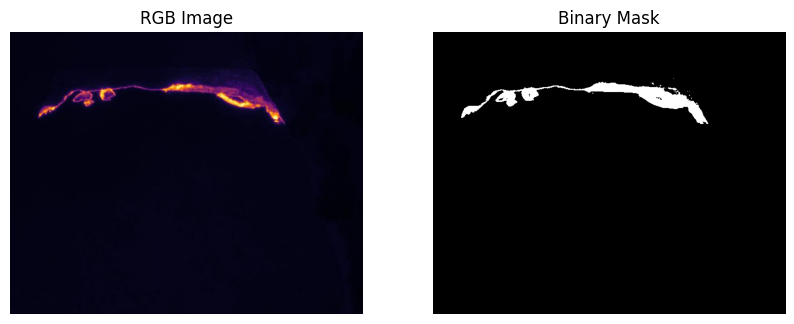

In [4]:
# LOAD IN ALL IMAGES AND OPTIMAL THRESHOLD CSV
dataset = 'Wilamette'
imageNum = '00001'
opt_df = pd.read_csv(f'./output_folders/{dataset}_OTSU/optimal_thresholds.csv')

# Load RGB image (OpenCV loads in BGR, convert it)
image_bgr = cv2.imread(f'./data/Images_{dataset}/Thermal/JPG_Calibrated/{imageNum}.JPG')
image_thermal = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

image_bgr = cv2.imread(f'./data/Images_{dataset}/RGB/{imageNum}.JPG')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
print(f'RGB/THERMAL IMAGE LOADED')

# Load single-channel Otsu TIFF as a NumPy array
image_otsu = cv2.imread(f'./output_folders/{dataset}_OTSU/{imageNum}.TIFF', cv2.IMREAD_UNCHANGED)
image_otsu = image_otsu.astype(np.uint8)  # Convert to uint8 if needed
print(f'OTSU TIFF LOADED')

# Load single-channel TIFF as a NumPy array
image_tiff = cv2.imread(f'./data/Images_{dataset}/Thermal/TIFF_Calibrated/{imageNum}.TIFF', cv2.IMREAD_UNCHANGED)  # Keep original depth
# image_tiff = image_tiff.astype(np.float32)  # Convert to uint8
# image_tiff = image_tiff.astype(np.int32)  # Convert to uint8
print(f'TIFF LOADED')

# Convert Otsu 255-mask to binary (0 and 1)
mask_binary = (image_otsu > 0).astype(np.uint8)

# Get unique values to verify conversion
unique_values = np.unique(mask_binary)
print("Unique pixel values:", unique_values)


# Create subplots to show images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display RGB image
axes[0].imshow(image_thermal)
axes[0].set_title("RGB Image")
axes[0].axis("off")

# Display binary mask
axes[1].imshow(mask_binary, cmap="gray")
axes[1].set_title("Binary Mask")
axes[1].axis("off")

# Show both images
plt.show()

### Identify Positive Points

Optimal Threshold for 00001.TIFF is: 104


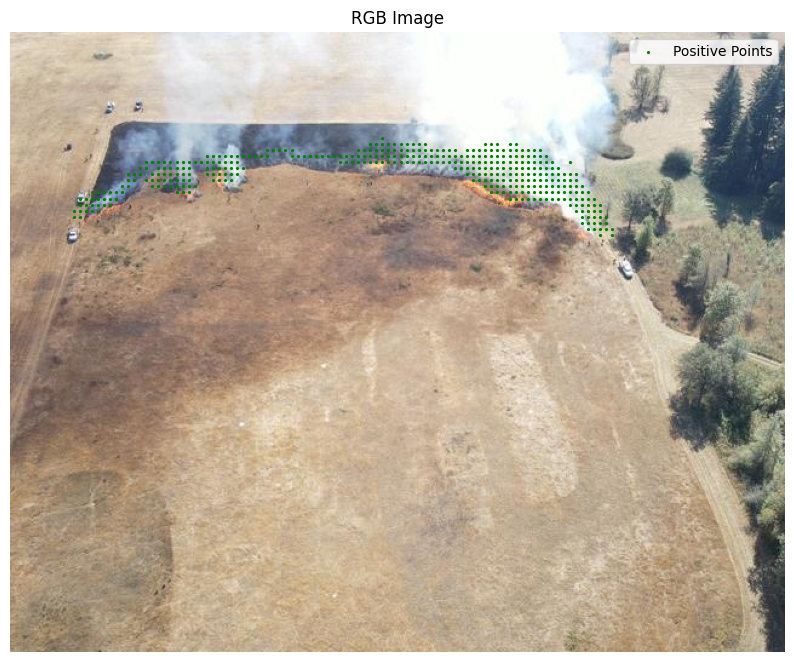

In [5]:
# Represents the locations determined to be positive points
positivePoints = []

# Patch size (rows, cols)
patchHeight = 5
patchWidth = 5
patch_size = (patchHeight, patchWidth)

# Extract patches using sliding window
patches = sliding_window_view(image_tiff, patch_size)[::patch_size[0], ::patch_size[1]]

# Get the starting row and col indices for each patch
rows, cols = np.meshgrid(
    np.arange(0, image_tiff.shape[0] - patch_size[0] + 1, patch_size[0]),
    np.arange(0, image_tiff.shape[1] - patch_size[1] + 1, patch_size[1]),
    indexing="ij"
)

# Flatten the indices and patches
patches = patches.reshape(-1, *patch_size)
patch_coords = np.column_stack((rows.ravel(), cols.ravel()))  # (num_patches, 2) -> (row, col)

# Get optimal threshold from CSV file
optimal_threshold = opt_df.loc[opt_df['Filename'] == f'{imageNum}.TIFF', 'Optimal Threshold'].values[0]
print(f"Optimal Threshold for {imageNum}.TIFF is: {optimal_threshold}")

# Print patches along with their center coordinates
for (r, c), patch in zip(patch_coords, patches):
    errorMargin = 25
    # Calculate the center of the patch
    r_center = r + patchHeight // 2
    c_center = c + patchWidth // 2
    
    # Condition to check mean intensity of the patch
    if patch.mean() >= optimal_threshold - errorMargin:
        positivePoints.append((c_center, r_center))  # Append center coordinates instead of top-left

# SHOW PLOT AND POINTS
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Display RGB image
ax.imshow(image_rgb)
ax.set_title("RGB Image")
ax.axis("off")

# Assuming positivePoints is a list of (row, col) coordinates
positivePoints = np.array(positivePoints)  # Convert list to NumPy array if not already
# scatter expects (x, y) (c, r) format, so swap row and column
ax.scatter(positivePoints[:, 0], positivePoints[:, 1], c='green', marker='1', s=5, label="Positive Points")

# Show legend and display the plot
ax.legend()
plt.show()


### Identify Negative Points

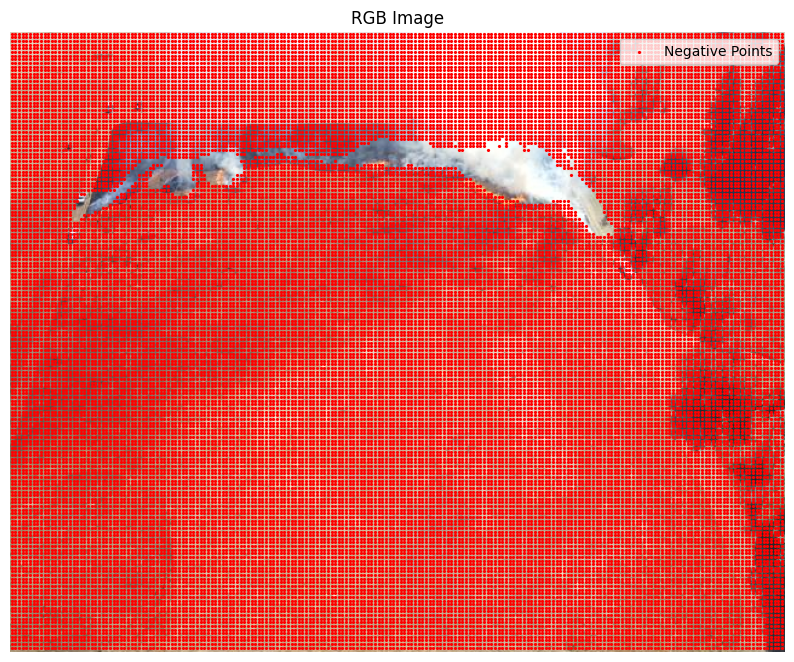

In [6]:
# Represents the locations determined to be negative points
negativePoints = []

# Patch size (rows, cols)
patchHeight = 3
patchWidth = 3

patch_size = (patchHeight, patchWidth)

# Extract patches using sliding window
patches = sliding_window_view(image_tiff, patch_size)[::patch_size[0], ::patch_size[1]]

# Get the starting row and col indices for each patch
rows, cols = np.meshgrid(
    np.arange(0, image_tiff.shape[0] - patch_size[0] + 1, patch_size[0]),
    np.arange(0, image_tiff.shape[1] - patch_size[1] + 1, patch_size[1]),
    indexing="ij"
)

# Flatten the indices and patches
patches = patches.reshape(-1, *patch_size)
patch_coords = np.column_stack((rows.ravel(), cols.ravel()))  # (num_patches, 2) -> (row, col)

# REMOVE UNWANTED NEGATIVE POINTS
for (r, c), patch in zip(patch_coords, patches):    
    if patch.mean() < optimal_threshold-errorMargin:
        # Calculate the center of the patch
        r_center = r + patchHeight // 2
        c_center = c + patchWidth // 2
        
        # Add the center coordinates to the negative points
        negativePoints.append((c_center, r_center))  # Use (col, row) format for coordinates

# SHOW PLOT AND POINTS
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Display RGB image
ax.imshow(image_rgb)
ax.set_title("RGB Image")
ax.axis("off")

# Assuming negativePoints is a list of (row, col) coordinates
negativePoints = np.array(negativePoints)  # Convert list to NumPy array if not already
if len(negativePoints) == 0 or len(positivePoints) == 0:
    print(f'SKIPPING IMAGE')
# scatter expects (x, y) (c, r) format, so swap row and column
ax.scatter(negativePoints[:, 0], negativePoints[:, 1], c='red', marker='2', s=5, label="Negative Points")

# Show legend and display the plot
ax.legend(loc="upper right")
plt.show()


### Visualize Both Positive and Negative Points

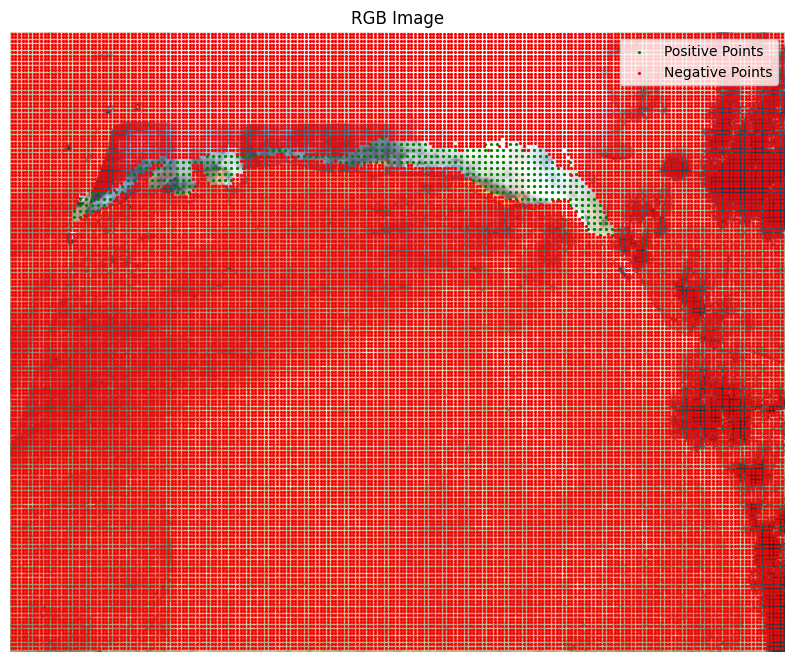

In [7]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Display RGB image
ax.imshow(image_rgb)
ax.set_title("RGB Image")
ax.axis("off")

# Convert lists to NumPy arrays if they aren't already
positivePoints = np.array(positivePoints)
negativePoints = np.array(negativePoints)

# Scatter plot for positive points (green)
ax.scatter(positivePoints[:, 0], positivePoints[:, 1], c='green', marker='1', s=5, label="Positive Points")

# Scatter plot for negative points (red)
ax.scatter(negativePoints[:, 0], negativePoints[:, 1], c='red', marker='2', s=5, label="Negative Points")

# Show legend and display the plot
ax.legend(loc="upper right")
plt.show()


### Apply Canny Edge Detection Filtering (Positive and Negative Point Filtering)

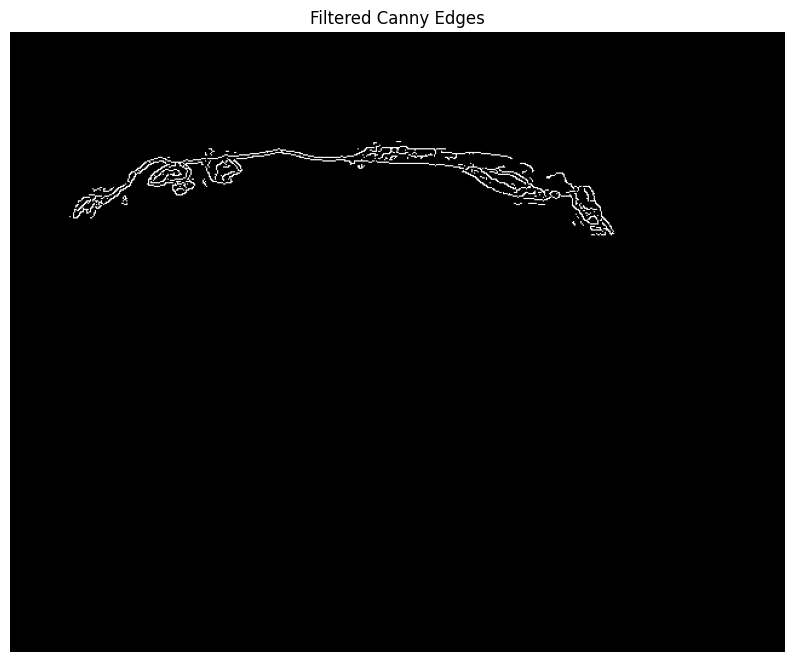

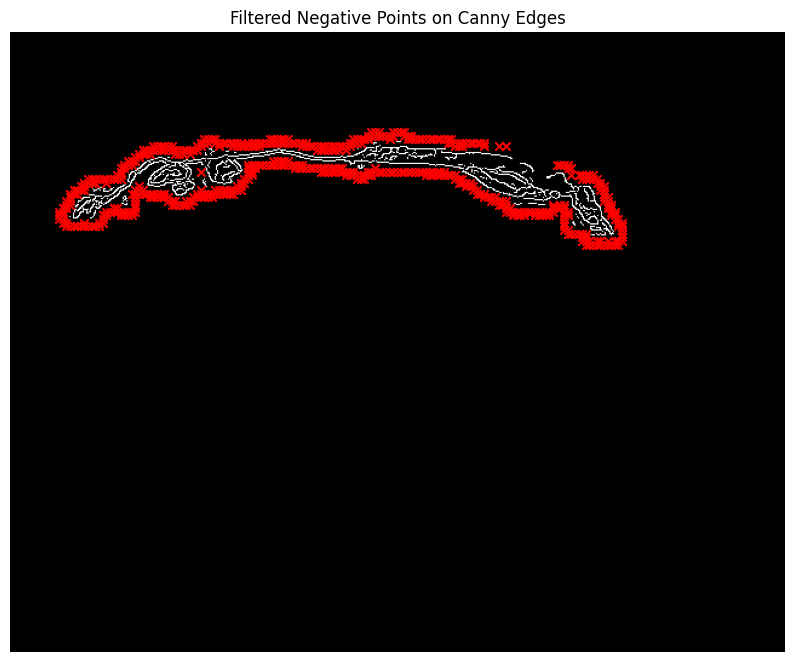

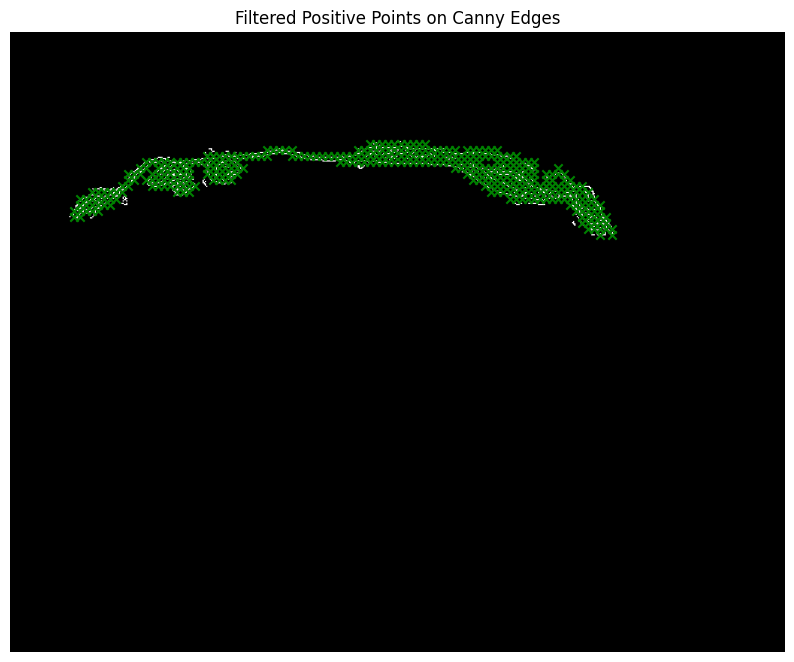

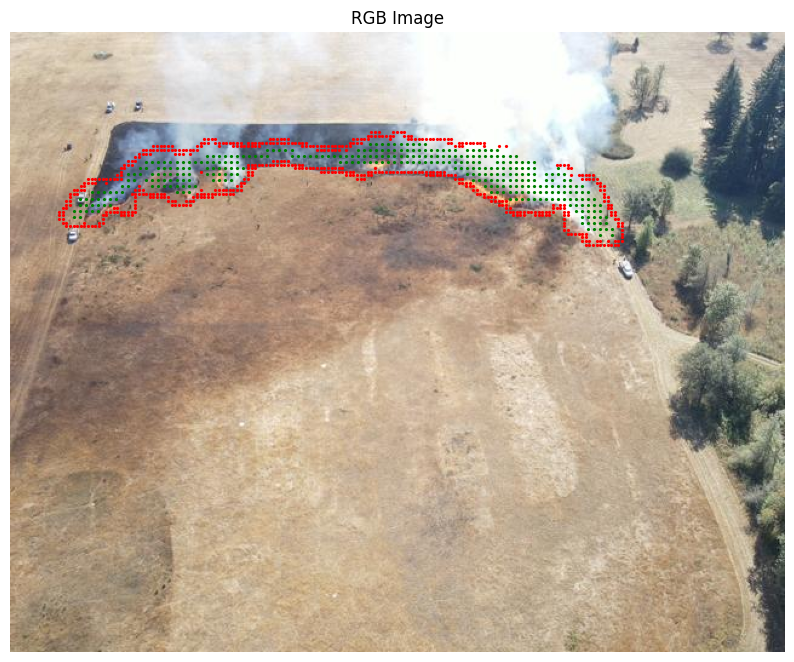

In [8]:
# Perform Canny edge detection
edges = cv2.Canny(image_thermal, threshold1=optimal_threshold, threshold2=200)

# Apply distance transform: computes the distance from each pixel to the nearest edge
distance_transform = distance_transform_edt(edges == 0)  # 0 means background (non-edge)

# Set a threshold distance (in pixels) to exclude points near the edges
inner_threshold = 5
outer_threshold = 10
# Create a mask where the distance transform is within the threshold (for negative points)
negative_mask = (distance_transform > inner_threshold) & (distance_transform < outer_threshold)

# Filter negative points based on the mask
filtered_negative_points = []
for point in negativePoints:
    col, row = point  # Negative points are in (col, row) format
    if negative_mask[row, col]:  # Check if the point is in the filtered area
        filtered_negative_points.append((col, row))

# For positive points, use a similar approach
distance_threshold_positive = 5
positive_mask = distance_transform < distance_threshold_positive  # Points near the edge

# Filter positive points based on the mask
filtered_positive_points = []
for point in positivePoints:
    col, row = point  # Positive points are in (col, row) format
    if positive_mask[row, col]:  # Check if the point is in the filtered area
        filtered_positive_points.append((col, row))

# Convert to a NumPy array for further use (if needed)
filtered_negative_points = np.array(filtered_negative_points)
filtered_positive_points = np.array(filtered_positive_points)

# Set a standard figure size
figsize = (10, 10)  # Or any size you prefer, e.g., (8, 6)


plt.figure(figsize=figsize)
plt.imshow(edges, cmap='gray')  # Display edges
plt.title('Filtered Canny Edges')
plt.axis('off')
plt.show()


# Filtered Negative Points on Edges
plt.figure(figsize=figsize)
plt.imshow(edges, cmap='gray')
for point in filtered_negative_points:
    col, row = point
    plt.scatter(col, row, color='red', marker='x')
plt.title('Filtered Negative Points on Canny Edges')
plt.axis('off')
plt.show()

# Filtered Positive Points on Edges
plt.figure(figsize=figsize)
plt.imshow(edges, cmap='gray')
for point in filtered_positive_points:
    col, row = point
    plt.scatter(col, row, color='green', marker='x')
plt.title('Filtered Positive Points on Canny Edges')
plt.axis('off')
plt.show()

# RGB Image with points
fig, ax = plt.subplots(figsize=figsize)
ax.imshow(image_rgb)
ax.set_title("RGB Image")
ax.axis("off")

# Scatter plot for positive points (green)
ax.scatter(filtered_positive_points[:, 0], filtered_positive_points[:, 1], c='green', marker='1', s=5, label="Positive Points")

# Scatter plot for negative points (red)
ax.scatter(filtered_negative_points[:, 0], filtered_negative_points[:, 1], c='red', marker='2', s=5, label="Negative Points")

# Show legend and display the plot
# ax.legend()
plt.show()


### Randomly Sample Positve and Negative Points

In [9]:
# take sample of points from positive points
positiveSample = filtered_positive_points[np.random.choice(len(filtered_positive_points), size=len(filtered_positive_points) // 10, replace=False)]
negativeSample = filtered_negative_points[np.random.choice(len(filtered_negative_points), size=len(filtered_negative_points) // 10, replace=False)]

### TIFF Usage, Copy Channels

In [10]:
# Convert single-channel to three-channel to use raw tiff input (only call this once otherwise channels will continue to duplicate)
image_tiff = cv2.merge([image_tiff, image_tiff, image_tiff])  # Copy the channel to R, G, and B
print(image_tiff.shape)

(512, 640, 3)


### Instantiate SamPredictor 

In [11]:
predictor = SamPredictor(sam)

### Input Positive and Negative Point Prompts, Prepare Image for Prediction

In [12]:
# NEGATIVE AND POSITIVE POINTS
# Define the coordinates of the points you want to use for prompting, (col, row) format for SAM
point_coords = np.vstack((positiveSample, negativeSample))

point_labels = np.concatenate((
    np.ones(len(positiveSample), dtype=int),   # 1s for positive points
    np.zeros(len(negativeSample), dtype=int)   # 0s for negative points
))

# Set the image for prediction, using THERMAL FOR THIS EXAMPLE, CAN USE RGB, THERMAL, OR TIFF
predictor.set_image(image_thermal)
masks, scores, logits = predictor.predict(point_coords=point_coords, point_labels=point_labels)


### Print Each SAM Mask Prediction Score

In [13]:
for i, (mask, score, logit) in enumerate(zip(masks, scores, logits)):
    print(f"Mask {i}:")
    print(f"Score: {score}")  # Print the confidence score


Mask 0:
Score: 0.8661087155342102
Mask 1:
Score: 0.9404020309448242
Mask 2:
Score: 0.9327812194824219


### Visualize Side-By-Side SAM Mask Predictions with Scores

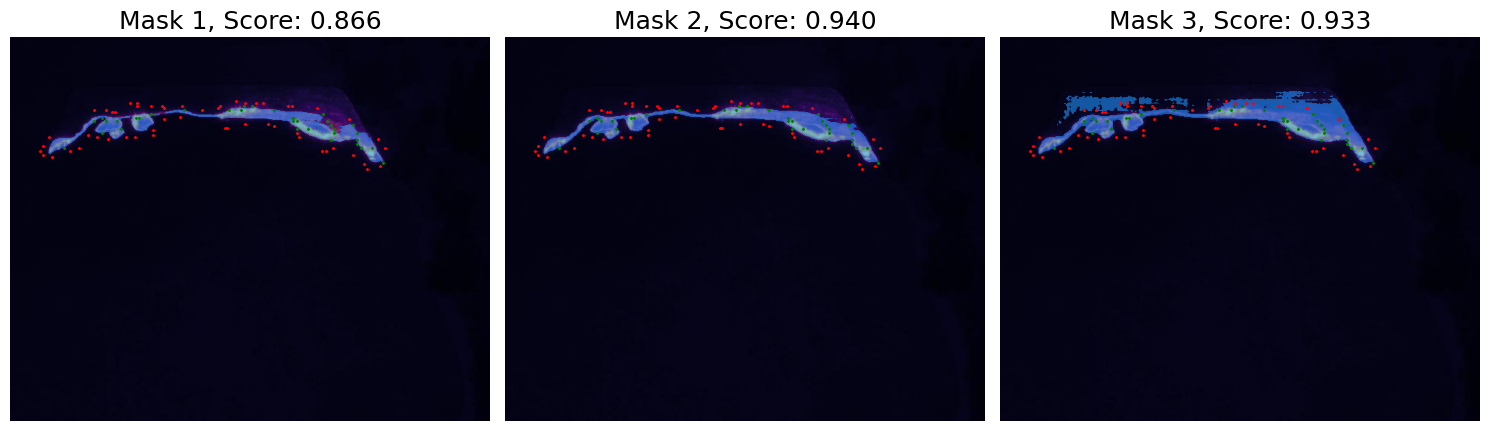

In [14]:
fig, axes = plt.subplots(1, len(masks), figsize=(5 * len(masks), 5))

# If only one mask, 'axes' will be a single axis, so handle it appropriately
if len(masks) == 1:
    axes = [axes]  # Make it iterable for consistency

for i, (mask, score) in enumerate(zip(masks, scores)):
    ax = axes[i]  # Get the subplot axis
    ax.imshow(image_thermal)
    show_mask(mask, ax)  # Assuming 'show_mask' works with axes
    show_points(point_coords, point_labels, ax)  
    # show_points(point_coords, point_labels, ax)  # Uncomment if you want to show points
    ax.set_title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    ax.axis('off')  # Hide the axis

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Define IOU Calculation

In [15]:
def iou(mask1, mask2):
    # Convert both masks to boolean (if they're not already)
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

### Compute TOPSIS Metrics, explained in SAM-TIFF Paper

In [16]:
# Convert SAM masks to binary (0 and 1)
sam_masks = [mask.astype(int) for mask in masks]
sam_masks = [np.uint8(mask) for mask in sam_masks]

# Get foreground pixel indices from the Otsu mask
otsu_indices = np.where(mask_binary == 1)

# Compute the mean temperature of Otsu mask foreground pixels
mean_otsu = np.mean(image_tiff[otsu_indices])

iou_values = np.array([])  # IoU (higher is better)
ssim_values = np.array([])  # SSIM (higher is better)
temp_diffs = np.array([])  # Mean Temp Diff (lower is better)
sam_scores = np.array([])  # SAM confidence (higher is better)
iou_thermals = np.array([])  # IoU of thermal image to SAM mask comparison

# Iterate through the 3 SAM masks
for i in range(3):
    # Compute IoUs
    iou_val = iou(masks[i], mask_binary)
    iou_values = np.append(iou_values, iou_val) 
    sam_scores = np.append(sam_scores, scores[i])
    
    # Extract the blue channel
    blue_channel = image_thermal[:, :, 2]  # Assuming image_thermal is RGB (height, width, 3)
    
    # Create a binary mask for foreground based on blue channel threshold
    blue_threshold = 28  # Adjust this threshold as needed
    black_pixels_mask = blue_channel > blue_threshold  # Mask for foreground (non-black)
    
    # Count black pixels
    black_pixel_count = np.sum(black_pixels_mask)
    # Get locations of black pixels (foreground pixels)
    black_pixel_locations = np.argwhere(black_pixels_mask)
    # Create the thermal mask for IoU comparison
    mask_thermal = black_pixels_mask.astype(np.uint8)  # Ensure it's an integer mask (0 or 1)
    
    # Compute IoU between SAM mask and thermal mask
    iou_thermal = iou(masks[i], mask_thermal)
    iou_thermals = np.append(iou_thermals, iou_thermal)
    
    # compute mean temperature difference
    # Get foreground pixel indices for the current SAM mask
    sam_indices = np.where(sam_masks[i] == 1)
    # Compute the mean temperature of the SAM mask's foreground pixels
    mean_sam = np.mean(image_tiff[sam_indices])
    # Compute absolute temperature difference
    temp_diff = abs(mean_otsu - mean_sam)
    temp_diffs = np.append(temp_diffs, temp_diff)
    
    # compute SSIM
    # Ensure both sets of pixels are the same length for SSIM computation
    min_size = min(len(otsu_indices[0]), len(sam_indices[0]))
    otsu_pixels = image_thermal[otsu_indices][:min_size]
    sam_pixels = image_thermal[sam_indices][:min_size]

    # Compute SSIM between the thermal values of the Otsu and SAM foreground pixels
    # Create blank images with the same shape as the thermal image (keeping 3 channels)
    otsu_thermal = np.zeros_like(image_thermal)
    sam_thermal = np.zeros_like(image_thermal)

    # Extract the foreground pixels and store them in new images
    otsu_thermal[mask_binary == 1] = image_thermal[mask_binary == 1]
    sam_thermal[sam_masks[i] == 1] = image_thermal[sam_masks[i] == 1]

    # Convert to grayscale for colormap application
    otsu_gray = cv2.cvtColor(otsu_thermal, cv2.COLOR_RGB2GRAY)
    sam_gray = cv2.cvtColor(sam_thermal, cv2.COLOR_RGB2GRAY)

    # Apply the inferno colormap (maps grayscale to color)
    otsu_colored = cv2.applyColorMap(cv2.normalize(otsu_gray, None, 0, 255, cv2.NORM_MINMAX), cv2.COLORMAP_INFERNO)
    sam_colored = cv2.applyColorMap(cv2.normalize(sam_gray, None, 0, 255, cv2.NORM_MINMAX), cv2.COLORMAP_INFERNO)

    # Compute SSIM for the inferno-mapped images (per channel and average)
    ssim_r, _ = ssim(otsu_colored[:, :, 0], sam_colored[:, :, 0], full=True)
    ssim_g, _ = ssim(otsu_colored[:, :, 1], sam_colored[:, :, 1], full=True)
    ssim_b, _ = ssim(otsu_colored[:, :, 2], sam_colored[:, :, 2], full=True)
    ssim_score = (ssim_r + ssim_g + ssim_b) / 3
    ssim_values = np.append(ssim_values, ssim_score)
    
    # Display images side by side
#     plt.figure(figsize=(12, 6))

#     plt.subplot(1, 2, 1)
#     plt.imshow(cv2.cvtColor(otsu_colored, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
#     plt.title("Otsu-Based Thermal Mask (Inferno)")
#     plt.axis("off")

#     plt.subplot(1, 2, 2)
#     plt.imshow(cv2.cvtColor(sam_colored, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
#     plt.title("SAM-Based Thermal Mask (Inferno)")
#     plt.axis("off")

#     plt.show()
    
    
    # Print results
    print(f'MASK {i+1}: IoU (Otsu vs. SAM) = {iou_val}; IoU (Thermal vs. SAM) = {iou_thermal}; SAM Score = {scores[i]}; '
          f'MEAN DIFFERENCE = {temp_diff:.4f}; SSIM Score = {ssim_score:.6f}')

# print(iou_values)
# print(ssim_values)
# print(temp_diffs)
# print(sam_scores)
# print(iou_thermals)

MASK 1: IoU (Otsu vs. SAM) = 0.8256232686980609; IoU (Thermal vs. SAM) = 0.2668522223188658; SAM Score = 0.8661087155342102; MEAN DIFFERENCE = 4.0853; SSIM Score = 0.992914
MASK 2: IoU (Otsu vs. SAM) = 0.848853775417692; IoU (Thermal vs. SAM) = 0.3143155331361976; SAM Score = 0.9404020309448242; MEAN DIFFERENCE = 14.4915; SSIM Score = 0.994378
MASK 3: IoU (Otsu vs. SAM) = 0.5087416522848353; IoU (Thermal vs. SAM) = 0.4949210166258966; SAM Score = 0.9327812194824219; MEAN DIFFERENCE = 84.2150; SSIM Score = 0.979054


### Apply TOPSIS Decision Making Approach

[0.42261484 0.55507587 0.55818766]
Best SAM mask: MASK 2 with TOPSIS score: 0.5582


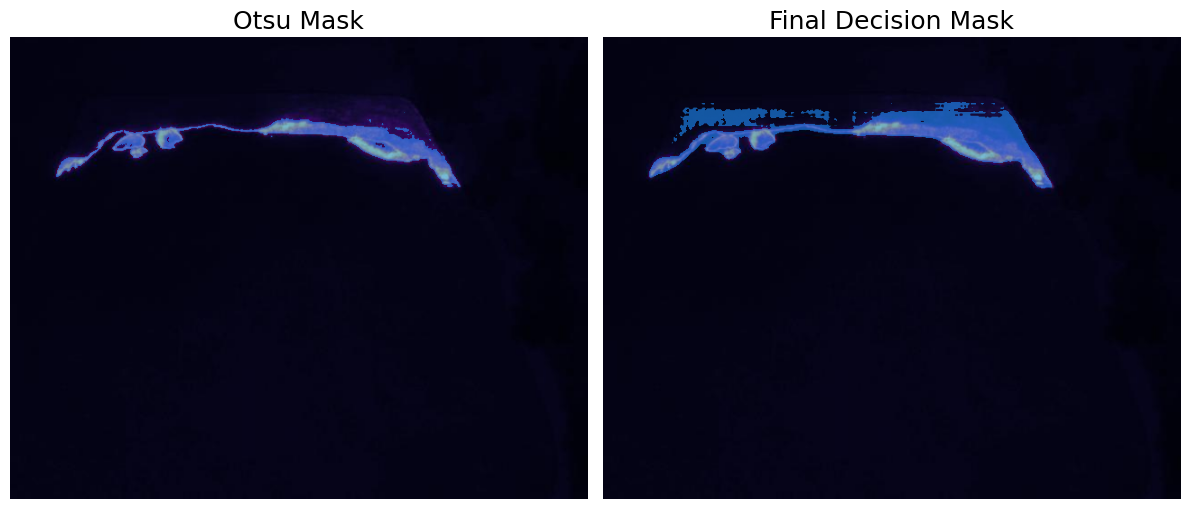

In [17]:
# Step 0: Assign weights to the metrics (higher weight for iou_thermals)
weights = np.array([1, 1, 1, 1, 2])  # The weight for iou_thermals is 2, others are 1

# Construct decision matrix (each row is a SAM mask, each column is a metric)
decision_matrix = np.vstack([iou_values, ssim_values, -temp_diffs, sam_scores, iou_thermals]).T  # Negative temp_diff since lower is better

# Step 1: Normalize the decision matrix using min-max norm
norm_matrix = np.zeros_like(decision_matrix)

for i in range(decision_matrix.shape[1]):
    min_val = np.min(decision_matrix[:, i])
    max_val = np.max(decision_matrix[:, i])
    # Perform Min-Max normalization
    norm_matrix[:, i] = (decision_matrix[:, i] - min_val) / (max_val - min_val)

# Step 2: Apply weights to the normalized decision matrix
weighted_norm_matrix = norm_matrix * weights  # Element-wise multiplication

# Step 3: Compute the ideal best and worst values
ideal_best = np.max(weighted_norm_matrix, axis=0)
ideal_worst = np.min(weighted_norm_matrix, axis=0)

# Step 4: Compute Euclidean distance from ideal best and ideal worst
dist_best = np.linalg.norm(weighted_norm_matrix - ideal_best, axis=1)
dist_worst = np.linalg.norm(weighted_norm_matrix - ideal_worst, axis=1)

# Step 5: Compute TOPSIS score
topsis_scores = dist_worst / (dist_best + dist_worst)

# Step 6: Select the best SAM mask
best_mask_idx = np.argmax(topsis_scores)  # Add 1 to match mask index (1-based)
print(topsis_scores)
print(f"Best SAM mask: MASK {best_mask_idx} with TOPSIS score: {topsis_scores[best_mask_idx]:.4f}")

# Display images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create two subplots

# Show the Otsu mask
ax1 = axes[0]
ax1.imshow(image_thermal, cmap='gray')  # Display the thermal image
show_mask(mask_binary, ax1)  # Display the Otsu mask
ax1.set_title("Otsu Mask", fontsize=18)
ax1.axis("off")

# Show the best TOPSIS mask
ax2 = axes[1]
ax2.imshow(image_thermal, cmap='gray')  # Display the thermal image
show_mask(masks[best_mask_idx], ax2)  # Display the best TOPSIS mask
ax2.set_title("Final Decision Mask", fontsize=18)
ax2.axis("off")

plt.tight_layout()  # Prevent overlap
plt.show()


### Save Final Decision Mask

In [18]:
# Convert the mask to uint8 (0 or 255) if it's binary
final_mask = masks[best_mask_idx]  # Your TOPSIS-selected mask
final_mask_uint8 = (final_mask.astype(np.uint8) * 255)  # Scale if mask is 0/1

# Create a PIL Image
mask_image = Image.fromarray(final_mask_uint8)

output_folder = f'output_folders/{dataset}_SAM_Masks'
os.makedirs(output_folder, exist_ok=True)

# Save as TIFF
mask_image.save(f'./{output_folder}/{imageNum}.TIFF')
print(f'Final decision mask saved as ./{output_folder}/{imageNum}.TIFF')


Final decision mask saved as ./output_folders/Wilamette_SAM_Masks/00001.TIFF
